In [1]:
#第3次训练，根据Step2的训练结果，更新标签

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data
import atecml.fs

from contextlib import contextmanager
from tqdm import tqdm
from time import strftime,time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from concurrent.futures import ProcessPoolExecutor

plt.style.use('ggplot')

In [3]:
train_df,test_df= atecml.data.load()
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
target ='Fraud'

predictors.append('NaN_LIST')

In [4]:

Gk =len(train_df[train_df['label'] ==0])  #Good Known
Bk =len(train_df[train_df['label'] ==1])  #Bad Known

#未标记前欺诈交易数据条数
print(Bk)

12122


In [5]:
'''
K = (Gk/Bk) / (Gi/Bi)
K ,consider AntFin's professional skills , predefined to more than 4.  
Gi/Bi = Gk/Bk / K
'''

K=2
Gi_Bi_ratio = Gk/Bk/K
Num_Bi = (1 / (Gi_Bi_ratio+1)) *len(train_df[train_df['label'] ==-1])

In [6]:
print(Num_Bi)

114.30964906678587


# 分析Reject_inf矩阵分布，并将可疑交易标记为Fraud

In [7]:
reject_df = pd.read_pickle('./reject_inf.dat')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bf9600e48>]],
      dtype=object)

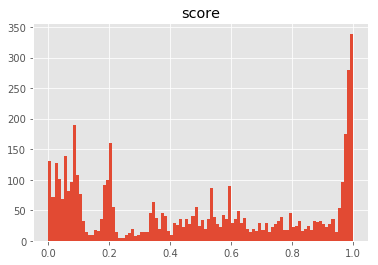

In [8]:
reject_df.hist(bins=100)

1067


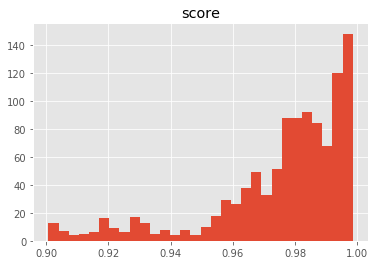

In [9]:
threshold = 0.9 # 大概未知交易中有20%是欺诈交易

filter_list = reject_df[reject_df.score > threshold]
filter_list.hist(bins=30)
reject_bad_list = list(filter_list['id'])
print(len(reject_bad_list))

In [10]:
train_df.loc[train_df['id'].isin(reject_bad_list),'Fraud'] = 1

In [11]:
#新的欺诈交易数量
len(train_df[train_df['Fraud'] ==1])

13189

In [12]:
#继续修正F5

train_df['f5'] =train_df['f5']//100
test_df['f5'] =test_df['f5']//100
a = train_df['f5'].unique()
test_df['f5'][~test_df['f5'].isin(a)] =np.nan

# 计算每个Feature的WOE/IV

In [13]:
iv_list = {}
woe_table = {}
type_list = {}

def mt_iv(feature):
    return atecml.data.calc_iv(df=train_df,feature=feature,target=target,category_num=64)

with ProcessPoolExecutor(max_workers=40) as pool:
    for pool_result in pool.map(mt_iv,predictors):
        iv = pool_result[0]
        woe_df = pool_result[1]
        feature_type = pool_result[2]
        iv_list.update(iv)
        woe_table.update(woe_df)
        type_list.update(feature_type)

[2018-07-03 15:02:19][WoE/IV Calculation for f2] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f1] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f3] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f4] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f5] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f7] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f6] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f8] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f9] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f14] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f17] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f18] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f20] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f16] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f15] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f22] Begin ...
[2018-07-03 15:02:19][WoE/IV Calculation for f21]

[2018-07-03 15:04:02][WoE/IV Calculation for f83] Begin ...
[2018-07-03 15:04:03][WoE/IV Calculation for f7] End   ...[Elapsed: 103.45s]
[2018-07-03 15:04:03][WoE/IV Calculation for f84] Begin ...
[2018-07-03 15:04:10][WoE/IV Calculation for f44] End   ...[Elapsed: 48.99s]
[2018-07-03 15:04:10][WoE/IV Calculation for f85] Begin ...
[2018-07-03 15:04:12][WoE/IV Calculation for f56] End   ...[Elapsed: 41.06s]
[2018-07-03 15:04:12][WoE/IV Calculation for f86] Begin ...
[2018-07-03 15:04:13][WoE/IV Calculation for f47] End   ...[Elapsed: 49.21s]
[2018-07-03 15:04:13][WoE/IV Calculation for f87] Begin ...
[2018-07-03 15:04:15][WoE/IV Calculation for f55] End   ...[Elapsed: 45.02s]
[2018-07-03 15:04:15][WoE/IV Calculation for f88] Begin ...
[2018-07-03 15:04:16][WoE/IV Calculation for f59] End   ...[Elapsed: 42.88s]
[2018-07-03 15:04:16][WoE/IV Calculation for f89] Begin ...
[2018-07-03 15:04:18][WoE/IV Calculation for f64] End   ...[Elapsed: 40.78s]
[2018-07-03 15:04:18][WoE/IV Calculation 

[2018-07-03 15:05:31][WoE/IV Calculation for f143] Begin ...
[2018-07-03 15:05:33][WoE/IV Calculation for f109] End   ...[Elapsed: 47.22s]
[2018-07-03 15:05:33][WoE/IV Calculation for f144] Begin ...
[2018-07-03 15:05:37][WoE/IV Calculation for f101] End   ...[Elapsed: 64.38s]
[2018-07-03 15:05:37][WoE/IV Calculation for f145] Begin ...
[2018-07-03 15:05:37][WoE/IV Calculation for f106] End   ...[Elapsed: 53.48s]
[2018-07-03 15:05:37][WoE/IV Calculation for f146] Begin ...
[2018-07-03 15:05:37][WoE/IV Calculation for f94] End   ...[Elapsed: 73.52s]
[2018-07-03 15:05:37][WoE/IV Calculation for f147] Begin ...
[2018-07-03 15:05:39][WoE/IV Calculation for f114] End   ...[Elapsed: 43.88s]
[2018-07-03 15:05:39][WoE/IV Calculation for f148] Begin ...
[2018-07-03 15:05:43][WoE/IV Calculation for f119] End   ...[Elapsed: 43.01s]
[2018-07-03 15:05:43][WoE/IV Calculation for f149] Begin ...
[2018-07-03 15:05:47][WoE/IV Calculation for f99] End   ...[Elapsed: 75.89s]
[2018-07-03 15:05:47][WoE/IV 

[2018-07-03 15:07:03][WoE/IV Calculation for f202] Begin ...
[2018-07-03 15:07:04][WoE/IV Calculation for f158] End   ...[Elapsed: 54.64s]
[2018-07-03 15:07:04][WoE/IV Calculation for f203] Begin ...
[2018-07-03 15:07:05][WoE/IV Calculation for f168] End   ...[Elapsed: 43.39s]
[2018-07-03 15:07:05][WoE/IV Calculation for f204] Begin ...
[2018-07-03 15:07:06][WoE/IV Calculation for f159] End   ...[Elapsed: 54.02s]
[2018-07-03 15:07:06][WoE/IV Calculation for f205] Begin ...
[2018-07-03 15:07:07][WoE/IV Calculation for f166] End   ...[Elapsed: 49.07s]
[2018-07-03 15:07:07][WoE/IV Calculation for f206] Begin ...
[2018-07-03 15:07:11][WoE/IV Calculation for f169] End   ...[Elapsed: 45.61s]
[2018-07-03 15:07:11][WoE/IV Calculation for f207] Begin ...
[2018-07-03 15:07:12][WoE/IV Calculation for f161] End   ...[Elapsed: 57.79s]
[2018-07-03 15:07:12][WoE/IV Calculation for f208] Begin ...
[2018-07-03 15:07:15][WoE/IV Calculation for f175] End   ...[Elapsed: 44.83s]
[2018-07-03 15:07:15][WoE/I

[2018-07-03 15:08:20][WoE/IV Calculation for f261] Begin ...
[2018-07-03 15:08:20][WoE/IV Calculation for f237] End   ...[Elapsed: 34.32s]
[2018-07-03 15:08:20][WoE/IV Calculation for f262] Begin ...
[2018-07-03 15:08:20][WoE/IV Calculation for f236] End   ...[Elapsed: 36.07s]
[2018-07-03 15:08:20][WoE/IV Calculation for f263] Begin ...
[2018-07-03 15:08:21][WoE/IV Calculation for f214] End   ...[Elapsed: 58.16s]
[2018-07-03 15:08:21][WoE/IV Calculation for f264] Begin ...
[2018-07-03 15:08:22][WoE/IV Calculation for f224] End   ...[Elapsed: 45.84s]
[2018-07-03 15:08:22][WoE/IV Calculation for f265] Begin ...
[2018-07-03 15:08:22][WoE/IV Calculation for f226] End   ...[Elapsed: 45.16s]
[2018-07-03 15:08:22][WoE/IV Calculation for f266] Begin ...
[2018-07-03 15:08:22][WoE/IV Calculation for f229] End   ...[Elapsed: 43.89s]
[2018-07-03 15:08:22][WoE/IV Calculation for f267] Begin ...
[2018-07-03 15:08:23][WoE/IV Calculation for f231] End   ...[Elapsed: 43.69s]
[2018-07-03 15:08:23][WoE/I

[2018-07-03 15:09:56][WoE/IV Calculation for NaN_LIST] End   ...[Elapsed: 51.03s]


# 特征IV分析

In [14]:
iv_df = pd.DataFrame()
iv_df['IV'] = pd.DataFrame.from_dict(iv_list,orient='index')[0]
iv_df['Type'] = pd.DataFrame.from_dict(type_list,orient='index')[0]
iv_df.sort_values('IV',ascending=False).head(100)

,IV,Type
f31,2.427941,category
f30,2.398790,category
f29,2.175538,category
f28,2.164650,category
f259,2.058093,value
f261,1.957455,value
f260,1.951096,value
f264,1.923087,value
f271,1.908920,value
f25,1.881609,category


In [15]:
iv_df.loc['NaN_LIST']

IV       0.81242
Type    category
Name: NaN_LIST, dtype: object

In [20]:
important_feature = list(iv_df[ (iv_df.IV > 0.3) & (iv_df.IV < 0.8)].index)
filter_feature = important_feature
#list(set(important_feature) -set(atecml.data.NOT_IMP_FEATURE))
print(len(filter_feature))
rename_dict ={}
for item in filter_feature:
    old_feature_name = item
    new_feature_name = 'n_' + item
    rename_dict[old_feature_name] = new_feature_name

182


# 使用WOE/IV结果对原有训练集特征纬度提升

In [17]:
def mt_conv_train(feature):
    return atecml.data.woe_convert(df=train_df,feature=feature,woe_table=woe_table,type_list=type_list,category_num=64)

new_feature =[]
with ProcessPoolExecutor(max_workers=60) as pool:
    for pool_result in pool.map(mt_conv_train,predictors):
        new_feature.append(pool_result)
        
_t_new_df = pd.concat(new_feature,axis=1)
_t_new_df = _t_new_df[filter_feature]

mean = _t_new_df.mean(axis=1)
variance = _t_new_df.var(axis=1)
skew = _t_new_df.skew(axis=1)
_t_new_df['mean'] = mean
#_t_new_df['variance'] = variance
#_t_new_df['skew'] = skew


_t_new_df.rename(columns=rename_dict,inplace=True)

ext_df = pd.concat([train_df,_t_new_df],axis=1)
ext_df.to_pickle('./train_new.dat')

In [18]:
test_df = atecml.data.load_test()
test_df['f5'] =test_df['f5']//100
test_df['f5'][~test_df['f5'].isin(a)] =np.nan

def mt_conv_test(feature):
    return atecml.data.woe_convert(df=test_df,feature=feature,woe_table=woe_table,type_list=type_list,category_num=64)

new_feature_tt =[]
with ProcessPoolExecutor(max_workers=60) as pool:
    for pool_result in pool.map(mt_conv_test,predictors):
        new_feature_tt.append(pool_result)
        
_t_new_tt_df = pd.concat(new_feature_tt,axis=1)
_t_new_tt_df = _t_new_tt_df[filter_feature]


mean = _t_new_tt_df.mean(axis=1)
variance = _t_new_tt_df.var(axis=1)
skew = _t_new_tt_df.skew(axis=1)
_t_new_tt_df['mean'] = mean
#_t_new_tt_df['variance'] = variance
#_t_new_tt_df['skew'] = skew

_t_new_tt_df.rename(columns=rename_dict,inplace=True)
ext_tt_df = pd.concat([test_df,_t_new_tt_df],axis=1)
ext_tt_df.to_pickle('./test_new.dat')